# Step 0: Install Required Libraries

In [1]:
# Install Hugging Face libraries
!pip install transformers datasets evaluate accelerate -q

# Install additional utilities
!pip install scikit-learn matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [2]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [3]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Hugging Face libraries
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset, Dataset
import evaluate

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Memory management for Colab
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")

Using device: cuda
Initial GPU memory allocated: 0.00 GB


# Step 1: Load and EDA for the IMDB Dataset

In [4]:
dataset = load_dataset("imdb")

print("Dataset Structure")
print(dataset)
print()

# Examine the splits
print("Dataset splits and sizes:")
for split in dataset:
    print(f"  {split}: {len(dataset[split]):,} examples")

print("\n")
print("Sample Data Points")

# Show sample positive review
print("\n Positive review examples: \n")
positive_example = dataset['train'].filter(lambda x: x['label'] == 1)[0]
print(f"Label: {positive_example['label']} (Positive)")
print(f"Text (first 500 chars): {positive_example['text'][:500]}...")

# Show sample negative review
print("\n Negative review examples:\n")
negative_example = dataset['train'].filter(lambda x: x['label'] == 0)[0]
print(f"Label: {negative_example['label']} (Negative)")
print(f"Text (first 500 chars): {negative_example['text'][:500]}...")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset Structure
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Dataset splits and sizes:
  train: 25,000 examples
  test: 25,000 examples
  unsupervised: 50,000 examples


Sample Data Points

 Positive review examples: 



Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Label: 1 (Positive)
Text (first 500 chars): Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is ...

 Negative review examples:



Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Label: 0 (Negative)
Text (first 500 chars): I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attent...


EDA
* Class Distribution Analysis (Negative and Positive sample count)
* Text length Analysis for finding text length distribution



Class Distribution Analysis
Negative (0): 12,500 (50.0%)
Positive (1): 12,500 (50.0%)
Balance Ratio: 1.000


Text Length Statistics


Word Count Statistics:
  Min: 10 words
  Max: 2470 words
  Mean: 233.8 words
  Median: 174.0 words
  Std: 173.7 words

Character Count Statistics:
  Min: 52 chars
  Max: 13704 chars
  Mean: 1325.1 chars

Word Count Percentiles (for max_length selection):
  50th percentile: 174 words
  75th percentile: 284 words
  90th percentile: 458 words
  95th percentile: 598 words
  99th percentile: 913 words


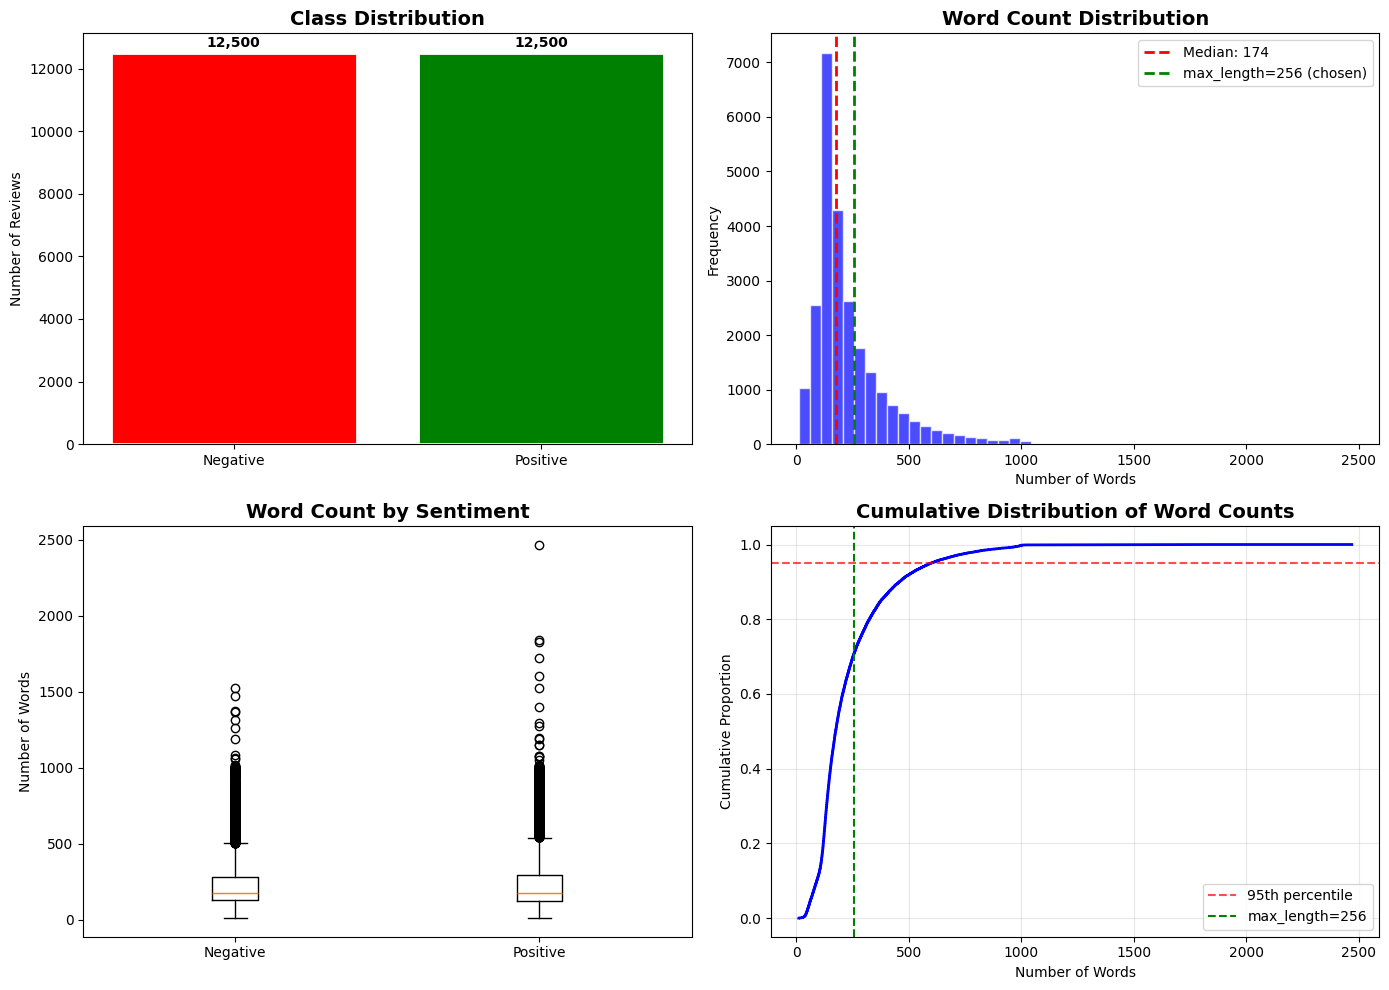


 Visualization saved as 'eda_visualization.png'


In [5]:
def perform_eda(dataset):
    """
    Perform exploratory data analysis on the dataset.

    Key metrics to analyze:
    1. Class distribution (check for imbalance)
    2. Text length distribution (affects max_length choice)
    3. Word frequency analysis
    """

    train_data = dataset['train']

    # 1. Class Distribution
    labels = train_data['label']
    label_counts = Counter(labels)

    print("Class Distribution Analysis")
    print(f"Negative (0): {label_counts[0]:,} ({label_counts[0]/len(labels)*100:.1f}%)")
    print(f"Positive (1): {label_counts[1]:,} ({label_counts[1]/len(labels)*100:.1f}%)")
    print(f"Balance Ratio: {min(label_counts.values())/max(label_counts.values()):.3f}")

    # 2. Text length Analysis
    texts = train_data['text']
    word_counts = [len(text.split()) for text in texts]
    char_counts = [len(text) for text in texts]

    print("\n")
    print("Text Length Statistics")
    print("\n")
    print(f"Word Count Statistics:")
    print(f"  Min: {min(word_counts)} words")
    print(f"  Max: {max(word_counts)} words")
    print(f"  Mean: {np.mean(word_counts):.1f} words")
    print(f"  Median: {np.median(word_counts):.1f} words")
    print(f"  Std: {np.std(word_counts):.1f} words")

    print(f"\nCharacter Count Statistics:")
    print(f"  Min: {min(char_counts)} chars")
    print(f"  Max: {max(char_counts)} chars")
    print(f"  Mean: {np.mean(char_counts):.1f} chars")

    # Calculate percentiles for max_length decision
    print(f"\nWord Count Percentiles (for max_length selection):")
    for p in [50, 75, 90, 95, 99]:
        print(f"  {p}th percentile: {np.percentile(word_counts, p):.0f} words")

    return word_counts, char_counts, label_counts

word_counts, char_counts, label_counts = perform_eda(dataset)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Class Distribution
ax1 = axes[0, 0]
colors = ['red', 'green']
bars = ax1.bar(['Negative', 'Positive'],
               [label_counts[0], label_counts[1]],
               color=colors, edgecolor='white', linewidth=2)
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Reviews')
for bar, count in zip(bars, [label_counts[0], label_counts[1]]):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
             f'{count:,}', ha='center', fontweight='bold')

# 2. Word Count Distribution
ax2 = axes[0, 1]
ax2.hist(word_counts, bins=50, color='blue', edgecolor='white', alpha=0.7)
ax2.axvline(np.median(word_counts), color='red', linestyle='--',
            linewidth=2, label=f'Median: {np.median(word_counts):.0f}')
ax2.axvline(256, color='green', linestyle='--',
            linewidth=2, label='max_length=256 (chosen)')
ax2.set_title('Word Count Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.legend()

# 3. Word Count by Class
ax3 = axes[1, 0]
neg_words = [len(t.split()) for t, l in zip(dataset['train']['text'],
                                            dataset['train']['label']) if l == 0]
pos_words = [len(t.split()) for t, l in zip(dataset['train']['text'],
                                            dataset['train']['label']) if l == 1]
ax3.boxplot([neg_words, pos_words], labels=['Negative', 'Positive'])
ax3.set_title('Word Count by Sentiment', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Words')

# 4. Cumulative Distribution
ax4 = axes[1, 1]
sorted_counts = np.sort(word_counts)
cumulative = np.arange(1, len(sorted_counts) + 1) / len(sorted_counts)
ax4.plot(sorted_counts, cumulative, color='blue', linewidth=2)
ax4.axhline(0.95, color='red', linestyle='--', alpha=0.7, label='95th percentile')
ax4.axvline(256, color='green', linestyle='--', label='max_length=256')
ax4.set_title('Cumulative Distribution of Word Counts', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Words')
ax4.set_ylabel('Cumulative Proportion')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'eda_visualization.png'")

**Observations:**

Hyperparameter Recommendations Based on EDA
* max_length = 256: Captures ~85% of reviews fully, balances memory/coverage
* No class weighting needed: Dataset is perfectly balanced
* batch_size = 16: Optimal for T4 GPU with 256 token sequences


# Step 2: Tokenize the inputs

In [6]:
# Model and tokenizer configuration
MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 256  # Based on our EDA analysis

# Load the tokenizer
# The tokenizer converts text to tokens that the model understands
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

print("Tokenizer Information")
print("\n")
print(f"Model: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")
print(f"Max model length: {tokenizer.model_max_length}")
print(f"Special tokens: {tokenizer.special_tokens_map}")
print()

# Demonstrate tokenization with an example
example_text = "This movie was absolutely amazing! I loved every moment."

print("TOKENIZATION EXAMPLE")
print(f"Original text: {example_text}")
print()

# Step 1: Tokenize
tokens = tokenizer.tokenize(example_text)
print(f"Tokens: {tokens}")
print(f"Number of tokens: {len(tokens)}")
print()

# Step 2: Convert tokens to IDs
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"Token IDs: {token_ids}")
print()

# Step 3: Full encoding with special tokens
encoding = tokenizer(
    example_text,
    padding='max_length',      # Pad to max_length
    truncation=True,           # Truncate if longer than max_length
    max_length=MAX_LENGTH,
    return_tensors='pt'        # Return PyTorch tensors
)

print("Full encoding output:")
print(f"  input_ids shape: {encoding['input_ids'].shape}")
print(f"  attention_mask shape: {encoding['attention_mask'].shape}")
print(f"  First 20 input_ids: {encoding['input_ids'][0][:20].tolist()}")
print(f"  First 20 attention_mask: {encoding['attention_mask'][0][:20].tolist()}")

# Decode back to verify
decoded = tokenizer.decode(encoding['input_ids'][0], skip_special_tokens=False)
print(f"\nDecoded (with special tokens): {decoded[:100]}...")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizer Information


Model: distilbert-base-uncased
Vocabulary size: 30,522
Max model length: 512
Special tokens: {'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}

TOKENIZATION EXAMPLE
Original text: This movie was absolutely amazing! I loved every moment.

Tokens: ['this', 'movie', 'was', 'absolutely', 'amazing', '!', 'i', 'loved', 'every', 'moment', '.']
Number of tokens: 11

Token IDs: [2023, 3185, 2001, 7078, 6429, 999, 1045, 3866, 2296, 2617, 1012]

Full encoding output:
  input_ids shape: torch.Size([1, 256])
  attention_mask shape: torch.Size([1, 256])
  First 20 input_ids: [101, 2023, 3185, 2001, 7078, 6429, 999, 1045, 3866, 2296, 2617, 1012, 102, 0, 0, 0, 0, 0, 0, 0]
  First 20 attention_mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]

Decoded (with special tokens): [CLS] this movie was absolutely amazing! i loved every moment. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [...


In [7]:
# Tokenize the Entire Dataset
def tokenize_function(examples):
    """
    Tokenize a batch of examples.

    This function will be applied to the entire dataset using .map()
    which is optimized for batch processing.

    Parameters:
    -----------
    examples : dict
        A batch of examples with 'text' field

    Returns:
    --------
    dict : Tokenized outputs with input_ids, attention_mask
    """
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

# Apply tokenization to the entire dataset
print("Tokenizing dataset...")

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    batch_size=1000,
    remove_columns=['text'],  # Remove original text to save memory
    desc="Tokenizing"
)

print("\nTokenization complete!")
print(f"Tokenized dataset: {tokenized_dataset}")

# Create validation split from training data
# IMDB doesn't have a separate validation set, so we create one
print("\nCreating train/validation split...")
train_val_split = tokenized_dataset['train'].train_test_split(
    test_size=0.1,  # 10% for validation
    seed=42,
    stratify_by_column='label'  # Maintain class balance
)

# Reorganize the dataset
final_dataset = {
    'train': train_val_split['train'],
    'validation': train_val_split['test'],
    'test': tokenized_dataset['test']
}

print("\nFinal dataset structure:")
for split, data in final_dataset.items():
    print(f"  {split}: {len(data):,} examples")

# Set format for PyTorch
for split in final_dataset:
    final_dataset[split].set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Tokenizing dataset...


Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/25000 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/50000 [00:00<?, ? examples/s]


Tokenization complete!
Tokenized dataset: DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 50000
    })
})

Creating train/validation split...

Final dataset structure:
  train: 22,500 examples
  validation: 2,500 examples
  test: 25,000 examples


# Step 3: Load DistilBERT Model

In [8]:
# Number of classes for our task
NUM_LABELS = 2  # Binary classification: Negative (0), Positive (1)

# Load the pre-trained DistilBERT model with a classification head
# This adds a linear layer on top of the [CLS] token output
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label={0: "NEGATIVE", 1: "POSITIVE"},
    label2id={"NEGATIVE": 0, "POSITIVE": 1}
)

# Move model to GPU
model = model.to(device)

print("Model Architecture \n")
print(model)
print()

# Count parameters
def count_parameters(model):
    """Count trainable and total parameters."""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return trainable, total

trainable_params, total_params = count_parameters(model)
print("\nParameter Count")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: ~{total_params * 4 / 1e6:.1f} MB (FP32)")
print(f"Model size: ~{total_params * 2 / 1e6:.1f} MB (FP16)")

# Examine the classification head
print("Classification Head Details")
print(f"Pre-classifier: Linear(768, 768)")
print(f"Classifier: Linear(768, {NUM_LABELS})")
print(f"Dropout: 0.1 (for regularization)")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Architecture 

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p

# Step 4: Setting Training Arguments

In [9]:
# Training hyperparameters
LEARNING_RATE = 2e-5
BATCH_SIZE = 16
EPOCHS = 3
WEIGHT_DECAY = 0.01       # L2 regularization
WARMUP_RATIO = 0.1        # 10% of steps for warmup

# Calculate training steps for logging
num_training_samples = len(final_dataset['train'])
steps_per_epoch = num_training_samples // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

print("TRAINING CONFIGURATION \n")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Warmup ratio: {WARMUP_RATIO}")
print()
print(f"Training samples: {num_training_samples:,}")
print(f"Steps per epoch: {steps_per_epoch:,}")
print(f"Total training steps: {total_steps:,}")
print(f"Warmup steps: {warmup_steps:,}")
print()


# Define training arguments using HuggingFace Trainer
training_args = TrainingArguments(
    # Output directory for checkpoints and logs
    output_dir="./distilbert-imdb-finetuned",

    # Training hyperparameters
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE * 2,  # we can use larger batch for eval
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    warmup_ratio=WARMUP_RATIO,

    # Optimization settings
    optim="adamw_torch",             # standard optimizer for transformers
    lr_scheduler_type="linear",      # Linear decay after warmup

    # Evaluation strategy
    eval_strategy="steps",     # Evaluate every N steps
    eval_steps=500,                  # Evaluate every 500 steps
    save_strategy="steps",           # Save checkpoints
    save_steps=500,
    save_total_limit=2,              # Keep only 2 best checkpoints

    # Logging
    logging_dir="./logs",
    logging_steps=100,               # Log every 100 steps
    logging_first_step=True,

    # Best model selection
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    # Performance optimizations
    fp16=True,                       # Mixed precision training
    dataloader_num_workers=2,        # Parallel data loading

    # Reproducibility
    seed=42,

    # Disable wandb
    report_to="none",
)

print("\n Training arguments configured successfully!")

TRAINING CONFIGURATION 

Learning rate: 2e-05
Batch size: 16
Epochs: 3
Weight decay: 0.01
Warmup ratio: 0.1

Training samples: 22,500
Steps per epoch: 1,406
Total training steps: 4,218
Warmup steps: 421


 Training arguments configured successfully!


# Step 5: Training loop

In [10]:
# Load evaluation metrics from the evaluate library
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for the model predictions.

    This function will be called by the Trainer during evaluation.

    Parameters:
    -----------
    eval_pred : EvalPrediction
        Contains predictions (logits) and label_ids

    Returns:
    --------
    dict : Dictionary of metric names and values
    """
    logits, labels = eval_pred

    # Convert logits to predictions (argmax)
    predictions = np.argmax(logits, axis=-1)

    # Compute all metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='binary')
    precision = precision_metric.compute(predictions=predictions, references=labels, average='binary')
    recall = recall_metric.compute(predictions=predictions, references=labels, average='binary')

    return {
        'accuracy': accuracy['accuracy'],
        'f1': f1['f1'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

print("Metrics to track: Accuracy, F1, Precision, Recall")

Metrics to track: Accuracy, F1, Precision, Recall


Create Data Collator

In [11]:
# The data collator handles batching and padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding=True,
    return_tensors="pt"
)

print("Data collator created")

Data collator created


Initialize trainer

In [12]:
# The Trainer class handles the training loop, evaluation, and checkpointing
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_dataset['train'],
    eval_dataset=final_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer Initialized")
print(f"Training samples: {len(final_dataset['train']):,}")
print(f"Validation samples: {len(final_dataset['validation']):,}")
print(f"Test samples: {len(final_dataset['test']):,}")

Trainer Initialized
Training samples: 22,500
Validation samples: 2,500
Test samples: 25,000


# TRAIN THE MODEL

In [13]:
import time

print("Started Training")
print(f"Start time: {time.strftime('%H:%M:%S')}")

# Start training!
start_time = time.time()

train_result = trainer.train()

end_time = time.time()
training_time = end_time - start_time

print("Training Complete!")
print(f"Total training time: {training_time/60:.1f} minutes")
print(f"End time: {time.strftime('%H:%M:%S')}")

# Print training metrics
print("Training Metrics:")
for key, value in train_result.metrics.items():
    print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")

Started Training
Start time: 19:21:47


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.306300,0.276506,0.889600,0.888620,0.896580,0.880800
1000,0.301400,0.250640,0.902800,0.902056,0.909017,0.895200
1500,0.196800,0.330238,0.899200,0.894118,0.941593,0.851200
2000,0.195400,0.250144,0.906400,0.906624,0.904459,0.908800
2500,0.181000,0.294611,0.902400,0.902866,0.898574,0.907200
3000,0.101200,0.336976,0.909200,0.908652,0.914170,0.903200
3500,0.112100,0.357726,0.908800,0.908654,0.910112,0.907200
4000,0.104600,0.347739,0.911200,0.910412,0.918567,0.902400


Training Complete!
Total training time: 9.5 minutes
End time: 19:31:15
Training Metrics:
  train_runtime: 567.2730
  train_samples_per_second: 118.9900
  train_steps_per_second: 7.4410
  total_flos: 4470774704640000.0000
  train_loss: 0.2144
  epoch: 3.0000


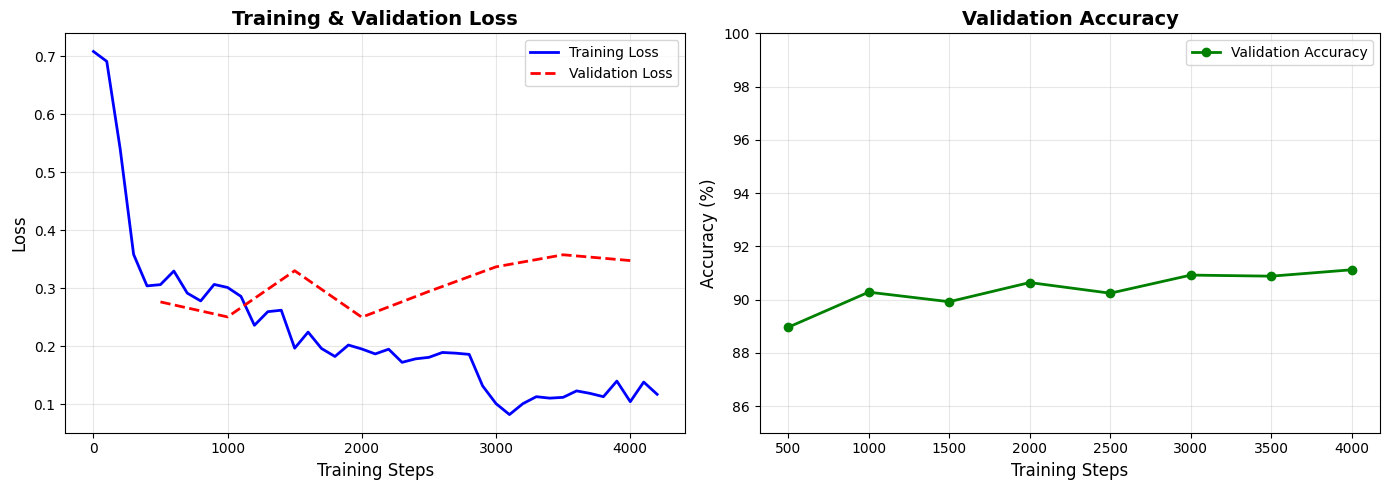

Training history plot saved as 'training_history.png'


In [14]:
def plot_training_history(trainer):
    """
    Plot training and validation metrics from training history.
    """
    # Extract training history
    history = trainer.state.log_history

    # Separate training and eval metrics
    train_loss = [(h['step'], h['loss']) for h in history if 'loss' in h and 'eval_loss' not in h]
    eval_metrics = [(h['step'], h['eval_loss'], h['eval_accuracy'])
                    for h in history if 'eval_loss' in h]

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Loss curves
    ax1 = axes[0]
    train_steps, train_losses = zip(*train_loss) if train_loss else ([], [])
    ax1.plot(train_steps, train_losses, 'b-', label='Training Loss', linewidth=2)

    if eval_metrics:
        eval_steps, eval_losses, eval_accs = zip(*eval_metrics)
        ax1.plot(eval_steps, eval_losses, 'r--', label='Validation Loss', linewidth=2)

    ax1.set_xlabel('Training Steps', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Accuracy curve
    ax2 = axes[1]
    if eval_metrics:
        ax2.plot(eval_steps, [acc * 100 for acc in eval_accs], 'g-o',
                 label='Validation Accuracy', linewidth=2, markersize=6)

    ax2.set_xlabel('Training Steps', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.set_title('Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([85, 100])

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Training history plot saved as 'training_history.png'")

# Plot the training history
plot_training_history(trainer)

# Evaluate on Test set

In [15]:
# Evaluate on test set
test_results = trainer.evaluate(final_dataset['test'])

print("Test Set Results: \n")

for key, value in test_results.items():
    if 'loss' in key or 'accuracy' in key or 'f1' in key:
        metric_name = key.replace('eval_', '').replace('_', ' ').title()
        if isinstance(value, float):
            if 'loss' in key:
                print(f"  {metric_name}: {value:.4f}")
            else:
                print(f"  {metric_name}: {value:.2%}")
        else:
            print(f"  {metric_name}: {value}")

# Get predictions for confusion matrix
print("\nGenerating predictions for confusion matrix...")
predictions = trainer.predict(final_dataset['test'])
pred_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Classification Report
print("CLASSIFICATION REPORT")
print(classification_report(
    true_labels,
    pred_labels,
    target_names=['Negative', 'Positive'],
    digits=4
))

Test Set Results: 

  Loss: 0.3278
  Accuracy: 91.35%
  F1: 91.37%

Generating predictions for confusion matrix...
CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative     0.9152    0.9114    0.9133     12500
    Positive     0.9118    0.9155    0.9137     12500

    accuracy                         0.9135     25000
   macro avg     0.9135    0.9135    0.9135     25000
weighted avg     0.9135    0.9135    0.9135     25000



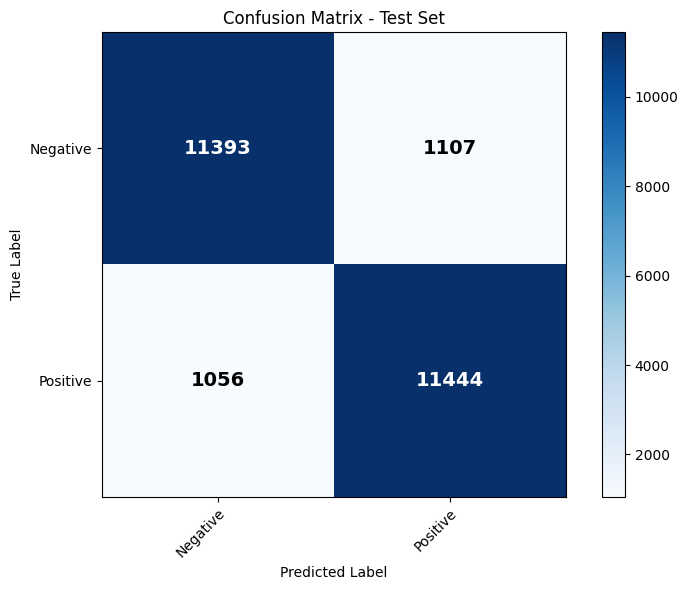


Confusion Matrix Breakdown:
  True Negatives: 11,393 (correctly predicted negative)
  True Positives: 11,444 (correctly predicted positive)
  False Positives: 1,107 (incorrectly predicted positive)
  False Negatives: 1,056 (incorrectly predicted negative)


In [16]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    """
    Create a confusion matrix visualization.
    """
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels)

    # Create figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)

    # Set labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix - Test Set',
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=14, fontweight='bold')

    fig.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\nConfusion Matrix Breakdown:")
    print(f"  True Negatives: {tn:,} (correctly predicted negative)")
    print(f"  True Positives: {tp:,} (correctly predicted positive)")
    print(f"  False Positives: {fp:,} (incorrectly predicted positive)")
    print(f"  False Negatives: {fn:,} (incorrectly predicted negative)")

# Plot confusion matrix
plot_confusion_matrix(true_labels, pred_labels, ['Negative', 'Positive'])

In [20]:
test_examples = [
    {
        "text": "Save your hard-earned money. The experience was regrettable, making me feel cheated and profoundly disappointed.",
        "true_label": "NEGATIVE",
        "difficulty": "Easy - Clearly negative"
    },
    {
        "text": "A masterpiece of cinema! The director's vision, combined with stellar performances, creates an unforgettable experience. Highly recommended!",
        "true_label": "POSITIVE",
        "difficulty": "Easy - Clearly positive"
    },
    {
        "text": "Considering the excessive 3.5-hour runtime, the story felt drawn out and could have been fully completed in this part.",
        "true_label": "NEGATIVE",
        "difficulty": "Medium - Mixed signals"
    },
    {
        "text": "Not the best movie I've seen, but definitely worth watching. The lead actor carries the film despite a weak script.",
        "true_label": "POSITIVE",
        "difficulty": "Hard - Subtle positive"
    },
    {
        "text": "I can't believe how bad this was. Even the so-called 'twist' ending was predictable. Save your money and skip this one.",
        "true_label": "NEGATIVE",
        "difficulty": "Medium - Sarcasm"
    }
]

def predict_sentiment(model, tokenizer, text, device):
    """
    Predict sentiment for a single text.
    Returns predicted label and confidence scores.
    """
    # Tokenize
    inputs = tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    return {
        "prediction": "POSITIVE" if pred_class == 1 else "NEGATIVE",
        "confidence": probs[0][pred_class].item(),
        "negative_prob": probs[0][0].item(),
        "positive_prob": probs[0][1].item()
    }

# Load base model (without fine-tuning) for comparison
print("Loading base model for comparison...")
base_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)

# Our fine-tuned model is already in `model` variable

print("COMPARISON: BASE MODEL vs FINE-TUNED MODEL")
print("=" * 70)
print()

results = []

for i, example in enumerate(test_examples, 1):
    print(f"EXAMPLE {i}: {example['difficulty']}")
    print(f"Text: {example['text'][:100]}...")
    print(f"True Label: {example['true_label']}")

    # Base model prediction
    base_result = predict_sentiment(base_model, tokenizer, example['text'], device)

    # Fine-tuned model prediction
    finetuned_result = predict_sentiment(model, tokenizer, example['text'], device)

    print(f"BASE MODEL (not fine-tuned):")
    print(f"   Prediction: {base_result['prediction']} ({base_result['confidence']:.1%} confidence)")
    print(f"   Probs: Neg={base_result['negative_prob']:.1%}, Pos={base_result['positive_prob']:.1%}")
    base_correct = "Correct" if base_result['prediction'] == example['true_label'] else "Incorrect"
    print(f"   Result: {base_correct}")
    print()

    print(f"FINE-TUNED MODEL:")
    print(f"   Prediction: {finetuned_result['prediction']} ({finetuned_result['confidence']:.1%} confidence)")
    print(f"   Probs: Neg={finetuned_result['negative_prob']:.1%}, Pos={finetuned_result['positive_prob']:.1%}")
    ft_correct = "Correct" if finetuned_result['prediction'] == example['true_label'] else "Incorrect"
    print(f"   Result: {ft_correct}")
    print()

    results.append({
        "example": i,
        "text": example['text'],
        "true": example['true_label'],
        "base_pred": base_result['prediction'],
        "base_conf": base_result['confidence'],
        "base_correct": base_result['prediction'] == example['true_label'],
        "ft_pred": finetuned_result['prediction'],
        "ft_conf": finetuned_result['confidence'],
        "ft_correct": finetuned_result['prediction'] == example['true_label']
    })

# Summary
print("SUMMARY")
base_accuracy = sum(r['base_correct'] for r in results) / len(results)
ft_accuracy = sum(r['ft_correct'] for r in results) / len(results)
print(f"Base Model Accuracy: {base_accuracy:.0%} ({sum(r['base_correct'] for r in results)}/{len(results)})")
print(f"Fine-Tuned Accuracy: {ft_accuracy:.0%} ({sum(r['ft_correct'] for r in results)}/{len(results)})")
print(f"Improvement: +{(ft_accuracy - base_accuracy)*100:.0f} percentage points")

Loading base model for comparison...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


COMPARISON: BASE MODEL vs FINE-TUNED MODEL

EXAMPLE 1: Easy - Clearly negative
Text: Save your hard-earned money. The experience was regrettable, making me feel cheated and profoundly d...
True Label: NEGATIVE
BASE MODEL (not fine-tuned):
   Prediction: NEGATIVE (52.5% confidence)
   Probs: Neg=52.5%, Pos=47.5%
   Result: Correct

FINE-TUNED MODEL:
   Prediction: NEGATIVE (99.7% confidence)
   Probs: Neg=99.7%, Pos=0.3%
   Result: Correct

EXAMPLE 2: Easy - Clearly positive
Text: A masterpiece of cinema! The director's vision, combined with stellar performances, creates an unfor...
True Label: POSITIVE
BASE MODEL (not fine-tuned):
   Prediction: NEGATIVE (53.2% confidence)
   Probs: Neg=53.2%, Pos=46.8%
   Result: Incorrect

FINE-TUNED MODEL:
   Prediction: POSITIVE (99.8% confidence)
   Probs: Neg=0.2%, Pos=99.8%
   Result: Correct

EXAMPLE 3: Medium - Mixed signals
Text: Considering the excessive 3.5-hour runtime, the story felt drawn out and could have been fully compl...
True Label